In [533]:
import simpy
import random
import matplotlib.pyplot as plt

In [534]:
NUMERO_RESPIRADORES = 35
NUMERO_CAMAS = 50
NUMERO_TEST = 120
TIEMPO_TEST_RAPIDO = 10
ninos = []
adultos = []
a_mayores = []


test_totales = []
ninos_fases = []
adultos_fases = []
a_mayores_fases = []


total = 479
poblacion = 15400
media = round((poblacion / total) * 3)
media

96

In [535]:
class Paciente:
    nombre = ''
    tipo = ''
    edad = 0
    estado = False
    genero = ''
    sintoma = False
    neumonia = False
    sobrevivio = True
    intensivo = False

    def __init__(self, nombre, tipo, edad, estado, genero, sintoma, neumonia, sobrevivio, intensivo):
        self.nombre = nombre
        self.tipo = tipo
        self.edad = edad
        self.estado = estado
        self.genero = genero
        self.sintoma = sintoma
        self.neumonia = neumonia
        self.sobrevivio = sobrevivio
        self.intensivo = intensivo
        

In [538]:
class Hospital:
    def __init__(self, env, num_respiradores, num_camas, num_test):
        self.env = env
        self.respiradores = simpy.Resource(env, num_respiradores)
        self.camas = simpy.Resource(env, num_camas)
        self.tests = simpy.Resource(env, num_test)
    def realizar_test(self, paciente):
        yield self.env.timeout(TIEMPO_TEST_RAPIDO)
        test_totales.append(paciente)
        if paciente.edad < 14:
            p = random.randint(0, 9)
            if p < 7:
                print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, 'NO PRESENTA COVID-19')
                paciente.estado = False
            else:
                print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, 'PRESENTA COVID-19, no es necesario hospitalizacion')
                paciente.estado = False
            ninos_fases.append(paciente)
        if paciente.edad > 14 and paciente.edad < 65:
            p = random.randint(0, 11)
            if p < 7:
                print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, 'PRESENTA COVID-19, pasa a fase 2')
                paciente.estado = True
            else:
                print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, 'NO PRESENTA COVID-19')
                paciente.estado = False
            adultos_fases.append(paciente)
                
        if paciente.edad > 64:
            p = random.randint(0, 11)
            if p < 8:
                print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, 'PRESENTA COVID-19, pasa a fase 2')
                paciente.estado = True
            else:
                print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, 'NO PRESENTA COVID-19')
                paciente.estado = False
            a_mayores_fases.append(paciente)
                    
    def fase_2(self, paciente):
        if paciente.edad > 14 and paciente.edad < 65:
            adultos_fases.append(paciente)
        elif paciente.edad > 64:
            a_mayores_fases.append(paciente)
        pro = random.randint(1, 5)
        if pro < 3:
            yield self.env.timeout(7)
            print('pasaron 7 Dias')
            print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, ' ha desarrollado un cuadro de NEUMONIA')
            paciente.neumonia = True
            
        else:
            yield self.env.timeout(15)
            print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, ' pasaron 15 Dias')
            print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, ' Se ha curado')
            paciente.estado = False
            
        
            
    def fase_3(self, paciente):
        yield self.env.timeout(7)
        print('Pasaron 7 Dias restantes')
        pos = self.posibilidad_supervivencia(paciente.edad)
        if pos:
            print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, ' Sobrevive y se cura')
        else:
            print('El paciente', paciente.nombre, ' con una edad de', paciente.edad, ' no cura dentro del rango y FALLECE')
            paciente.sobrevivio = False
        paciente.intensivo = True
        
        if paciente.edad > 14 and paciente.edad < 65:
            adultos_fases.append(paciente)
        elif paciente.edad > 64:
            a_mayores_fases.append(paciente)
        
    def posibilidad_supervivencia(self, edad):
        pbl = True
        if edad < 65 and edad > 14:
            pr1 = random.randint(1, 10)
            if pr1 <= 6:
                pbl = True
            else:
                pbl = False
        if edad > 65:
            pr2 = random.randint(1, 10)
            if pr2 < 4:
                pbl = True
            else:
                pbl = False
            
    def fase_final(self, paciente):
        print('')
        

In [539]:
def llegada_paciente(env, paciente, hospital):
    print('Llega el paciente: %s a la hora %.2f' %(paciente.nombre, env.now), ' con una edad de', paciente.edad)
    with hospital.tests.request() as test:
        yield test
        yield env.process(hospital.realizar_test(paciente))
    if paciente.estado:
        with hospital.camas.request() as cama:
            yield cama
            print('El paciente empieza la FASE 2', paciente.nombre, ' con una edad de', paciente.edad, 'se asigna una cama a la Hora: ',env.now)
            yield env.process(hospital.fase_2(paciente))
    if paciente.neumonia:
        with hospital.respiradores.request() as respirador:
            yield respirador
            print('El paciente empieza la FASE 3', paciente.nombre, ' con una edad de', paciente.edad, 'se asigna un respirador a la Hora: ',env.now)
            yield env.process(hospital.fase_3(paciente))

In [540]:
generar()
def ejecutar(env, num_respiradores, num_camas, num_test):
    hospital = Hospital(env, num_respiradores, num_camas, num_test)
    for i in range(1, 100):
        yield env.timeout(12-2, 12+2)
        for nj in ninos:
            env.process(llegada_paciente(env, nj, hospital))
        yield env.timeout(10-2, 10+2)
        for ad in adultos:
            env.process(llegada_paciente(env, ad, hospital))
        yield env.timeout(8-2, 8+2 )
        for am in a_mayores:
            env.process(llegada_paciente(env, am, hospital))
    while True:
        yield env.timeout(12-2, 12+2)
        for nj in ninos:
            env.process(llegada_paciente(env, nj, hospital))
        yield env.timeout(10-2, 10+2)
        for ad in adultos:
            env.process(llegada_paciente(env, ad, hospital))
        yield env.timeout(8-2, 8+2 )
        for am in a_mayores:
            env.process(llegada_paciente(env, am, hospital))
    
        
env=simpy.Environment()
env.process(ejecutar(env, NUMERO_RESPIRADORES, NUMERO_CAMAS, NUMERO_TEST))
env.run(until = media)

reporte()

Llega el paciente: paciente(2) a la hora 10.00  con una edad de 1
Llega el paciente: paciente(13) a la hora 10.00  con una edad de 11
Llega el paciente: paciente(17) a la hora 10.00  con una edad de 10
Llega el paciente: paciente(29) a la hora 10.00  con una edad de 3
Llega el paciente: paciente(32) a la hora 10.00  con una edad de 13
Llega el paciente: paciente(35) a la hora 10.00  con una edad de 13
Llega el paciente: paciente(40) a la hora 10.00  con una edad de 13
Llega el paciente: paciente(49) a la hora 10.00  con una edad de 2
Llega el paciente: paciente(62) a la hora 10.00  con una edad de 5
Llega el paciente: paciente(86) a la hora 10.00  con una edad de 13
Llega el paciente: paciente(95) a la hora 10.00  con una edad de 2
Llega el paciente: paciente(1) a la hora 18.00  con una edad de 26
Llega el paciente: paciente(4) a la hora 18.00  con una edad de 35
Llega el paciente: paciente(5) a la hora 18.00  con una edad de 37
Llega el paciente: paciente(6) a la hora 18.00  con una e

El paciente paciente(67)  con una edad de 43  pasaron 15 Dias
El paciente paciente(67)  con una edad de 43  Se ha curado
El paciente paciente(68)  con una edad de 47  pasaron 15 Dias
El paciente paciente(68)  con una edad de 47  Se ha curado
El paciente paciente(74)  con una edad de 41  pasaron 15 Dias
El paciente paciente(74)  con una edad de 41  Se ha curado
El paciente paciente(78)  con una edad de 20  pasaron 15 Dias
El paciente paciente(78)  con una edad de 20  Se ha curado
El paciente paciente(80)  con una edad de 45  pasaron 15 Dias
El paciente paciente(80)  con una edad de 45  Se ha curado
El paciente paciente(82)  con una edad de 45  pasaron 15 Dias
El paciente paciente(82)  con una edad de 45  Se ha curado
El paciente paciente(83)  con una edad de 52  pasaron 15 Dias
El paciente paciente(83)  con una edad de 52  Se ha curado
El paciente paciente(87)  con una edad de 48  pasaron 15 Dias
El paciente paciente(87)  con una edad de 48  Se ha curado
El paciente paciente(94)  con un

El paciente paciente(93)  con una edad de 80 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(96)  con una edad de 94 NO PRESENTA COVID-19
El paciente paciente(98)  con una edad de 78 PRESENTA COVID-19, pasa a fase 2
El paciente empieza la FASE 2 paciente(3)  con una edad de 95 se asigna una cama a la Hora:  58
El paciente empieza la FASE 2 paciente(14)  con una edad de 85 se asigna una cama a la Hora:  58
El paciente empieza la FASE 2 paciente(19)  con una edad de 85 se asigna una cama a la Hora:  58
El paciente empieza la FASE 2 paciente(23)  con una edad de 75 se asigna una cama a la Hora:  58
El paciente empieza la FASE 2 paciente(24)  con una edad de 66 se asigna una cama a la Hora:  58
El paciente empieza la FASE 3 paciente(25)  con una edad de 81 se asigna un respirador a la Hora:  58
El paciente empieza la FASE 2 paciente(31)  con una edad de 89 se asigna una cama a la Hora:  58
El paciente empieza la FASE 2 paciente(33)  con una edad de 85 se asigna una cama a la Hora:  5

El paciente paciente(57)  con una edad de 42 NO PRESENTA COVID-19
El paciente paciente(59)  con una edad de 15 NO PRESENTA COVID-19
El paciente paciente(61)  con una edad de 27 NO PRESENTA COVID-19
El paciente paciente(63)  con una edad de 26 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(64)  con una edad de 55 NO PRESENTA COVID-19
El paciente paciente(66)  con una edad de 35 NO PRESENTA COVID-19
El paciente paciente(67)  con una edad de 43 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(68)  con una edad de 47 NO PRESENTA COVID-19
El paciente paciente(69)  con una edad de 41 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(71)  con una edad de 40 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(74)  con una edad de 41 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(76)  con una edad de 47 NO PRESENTA COVID-19
El paciente paciente(78)  con una edad de 20 PRESENTA COVID-19, pasa a fase 2
El paciente paciente(79)  con una edad de 49 PRESENTA COVID-19, pasa a

El paciente paciente(100)  con una edad de 39  Se ha curado
El paciente paciente(101)  con una edad de 18  pasaron 15 Dias
El paciente paciente(101)  con una edad de 18  Se ha curado
El paciente empieza la FASE 3 paciente(67)  con una edad de 43 se asigna un respirador a la Hora:  91
El paciente empieza la FASE 3 paciente(74)  con una edad de 41 se asigna un respirador a la Hora:  91
El paciente empieza la FASE 3 paciente(90)  con una edad de 29 se asigna un respirador a la Hora:  91
El paciente empieza la FASE 3 paciente(94)  con una edad de 43 se asigna un respirador a la Hora:  91
El paciente empieza la FASE 3 paciente(100)  con una edad de 39 se asigna un respirador a la Hora:  91
El paciente empieza la FASE 3 paciente(101)  con una edad de 18 se asigna un respirador a la Hora:  91
El paciente paciente(2)  con una edad de 1 NO PRESENTA COVID-19
El paciente paciente(13)  con una edad de 11 NO PRESENTA COVID-19
El paciente paciente(17)  con una edad de 10 NO PRESENTA COVID-19
El paci

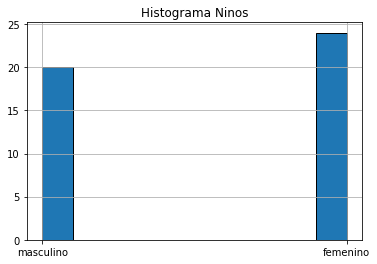

In [582]:
plt.title('Histograma Ninos')
plt.hist([ninos_fases[i].genero for i in range(len(ninos_fases))], bins=10, alpha=1, edgecolor = 'black',  linewidth=1)
plt.grid(True)


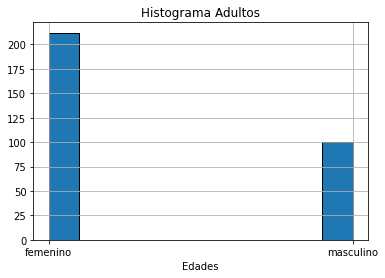

In [583]:
plt.title('Histograma Adultos')
plt.hist([adultos_fases[i].genero for i in range(len(adultos_fases))], bins=10, alpha=1, edgecolor = 'black',  linewidth=1)
plt.xlabel('Edades')
plt.grid(True)
plt.show()

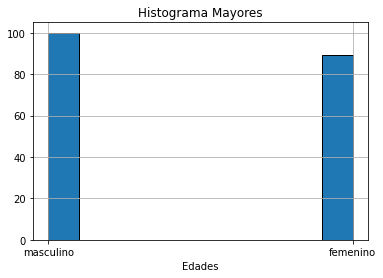

In [584]:
plt.title('Histograma Mayores')
plt.hist([a_mayores_fases[i].genero for i in range(len(a_mayores_fases))], bins=10, alpha=1, edgecolor = 'black',  linewidth=1)
plt.xlabel('Edades')
plt.grid(True)
plt.show()

In [463]:
#generamos 100 pacientes aleatoriamente, respetando los porcentajes
def generar():
    for i in range(1, 102):
        edad = random.randint(0, 100)
        if edad > 0 and edad < 14:
            pro = random.randint(0, 14)
            g = ''
            if pro < 8:
                g = 'femenino'
            else:
                g = 'masculino'
            paciente = Paciente('paciente(%d)'% i, 'nino', edad, False, g, False, False, True, False)
            ninos.append(paciente)
        elif edad > 14 and edad < 65:
            pro = random.randint(0, 14)
            g = ''
            if pro < 8:
                g = 'femenino'
            else:
                g = 'masculino'
            paciente = Paciente('paciente(%d)'% i, 'adulto', edad, False, g, True, False, True, False)
            adultos.append(paciente)
        elif edad > 65:
            pro = random.randint(0, 14)
            g = ''
            if pro < 8:
                g = 'femenino'
            else:
                g = 'masculino'
            paciente = Paciente('paciente(%d)'% i, 'mayor', edad, False, g, True, False, True, False)
            a_mayores.append(paciente)


In [471]:
def reporte():
    print('DETALLES')
    print(' TOTAL   SINTOMAS  NEUMONIA  INTENSIVO FALLECIDOS CURADOS  TOTAL')
    count(ninos_fases)
    count(adultos_fases)
    count(a_mayores_fases)
    

def count(paciente):
    sintomas = 0
    neumonia = 0
    intensivo = 0
    sobrevivio = 0
    curados = 0
    muerte = 0
    total = 0
    n = 0
    a = 0
    m = 0
    for pac in paciente:
        if pac.sintoma:
            sintomas += 1
        if pac.neumonia:
            neumonia += 1
        if pac.intensivo:
            intensivo += 1
        if pac.sobrevivio == False:
            muerte += 1
        else:
            sobrevivio += 1
        if pac.tipo == 'nino':
            n += 1
        if pac.tipo == 'adulto':
            a += 1
        if pac.tipo == 'mayor':
            m += 1
    if pac.edad < 14:
        print('Ninos       ', sintomas,'       ', neumonia,'        ',intensivo,'     ',muerte,'     ',sobrevivio, '    ', len(paciente))
    if pac.edad > 14 and pac.edad < 65:
        print('Adultos     ', sintomas, '     ', neumonia,'     ',intensivo,'       ',muerte,'     ',sobrevivio, '    ', len(paciente))
    if pac.edad > 64:
        print('Mayores     ', sintomas,'     ', neumonia,'     ',intensivo,'       ',muerte,'     ',sobrevivio, '    ', len(paciente))
            
    return [sintomas, neumonia, intensivo, sobrevivio, sobrevivio, n, m, a, pac.edad]